In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import jit, lax, grad

In [3]:
matplotlib.style.use('seaborn-colorblind')

In this notebook, I want to do two things:

- Revisit implementation of the Euler method for numerical integration using the [JAX](https://jax.readthedocs.io/en/latest/) package.
- Discuss a way of modifying the dynamics for a given vector field so that the long-term performance of the Euler method is greatly improved.

The second point was introduced in the paper "[Feedback Integrators](https://arxiv.org/abs/1606.05005)", by Dong Eui Chang, Fernando Jiménez, and Mathew Perlmutter (2016). Their method works for arbitrary integrators, not just Euler, but I will stick to that one for simplicity.

Why JAX? JAX provides two primitives that are useful for numerical integration, especially in the context of mechanical systems:

1. Automatic differentiation (`jax.grad`). ODEs for mechanical systems are full of gradients, and computing those by hand is no fun. JAX provides a convenient way to compute exact gradients. 
2. `jax.lax.scan`: Allows for updating a state across an array using a fixed prescription. This is the key to implementing fast numerical integrators without having to resort to compiled code or dirty tricks.

Note that I'm not a JAX programmer and my code is probably suboptimal and idiosyncratic (in fact, I started this notebook partly to become more proficient with JAX). Nevertheless, it's remarkable how easy it is to build an efficient and elegant numerical integrator with JAX. All that you need to code up is the vector field, and JAX takes care of the rest. Laboriously calculating gradients by hand, worrying over vectorized loops, etc. seem like a thing of the past.

# The Euler method

The Euler method is without doubt the simplest numerical integrator there is. Given a dynamical system $\dot{x} = X(t, x)$, with $X$ a vector field in $\mathbb{R}^n$, the Euler method provides a discrete approximation to the dynamics given by 
$$
  x_{n + 1} = x_n + h X(t, x_n),
$$
with $h$ the step size. 

This is a first-order method (meaning that the error between the discrete and continuous trajectories after one iteration is $O(h^2)$). It has the advantage of being _explicit_: finding $x_{n + 1}$ is a simple matter of plugging $x_n$ into the update rule, and in particular you don't need to solve an equation for $x_{n + 1}$. This makes it really easy to code up the Euler method.

This simplicity comes with a cost, however: the Euler method is not accurate over long stretches of time, and numerical trajectories will show systematic deviations from the continuous dynamics. For this reason, the method is not often used in practice, and other methods such as Stormer-Verlet, Runge-Kutta, etc. are preferred.

## In pure Python

Let's start by coding up the Euler method for the harmonic oscillator. Throughout this notebook, all my vector fields will be functions of two variables `t` and `x`, where `t` denotes time and `x` is an array containing the state of our system (usually position and velocity).

In [4]:
@jit
def harmonic_oscillator(t, x):
    q, p = x
    return jnp.array([p, -q])

In [5]:
def euler_one_step(X, t, x, h):
    return x + h*X(t, x)

At this point, we can slot `euler_one_step` into a for-loop and compute many updates over time. However, let's complicate things a little and factor out the updating over time from the details of the method. I do this in order to work towards what JAX has to offer.

In particular, JAX has a function `jax.lax.scan` which will repeatedly call a given function ("scan") across an array, carrying along a certain state (which is also modified by the function). This is quite a useful primitive, to implement (LSTM) neural networks, Viterbi decoders, etc. -- anything where you want to update some state along a given array, by means of a fixed rule. For a numerical integrator, the "state" that we want to carry along is precisely the (position, velocity) vector of the system, and the input array is the sequence of time points along which you want to integrate.

The `scan` function makes no assumptions about what it is you want to do, and can be implemented in pure Python as below. In pseudo-notation, it has the following signature: 
```
scan :: (c -> a -> (c, b)) -> c -> [a] -> (c, [b])

```
This is quite a handful, but boils down to the fact that it takes three arguments:
1. A function which itself takes two arguments, a state and an input element, and returns two values, a modified state and an output element;
2. An initial state;
3. An iterable of inputs.

The outputs are the modified state after all the iterations are done, and all of the outputs.

In [6]:
def scan(f, init, xs):
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)
        ys.append(y)
    return carry, ys

The first argument of `scan` looks like the `euler_one_step` method above, but the arguments and return values are not quite in the right place. To match things up, we can transform it as follows.

In [7]:
def transform_one_step(X, h, one_step):
    def transformed(x, t):
        res = one_step(X, t, x, h)
        return (res, res)
    return transformed

Pulling everything together, we get a method that can integrate a given vector field from time $t_0$ to $t_1$ with a one step method.

In [8]:
def integrate_python(X, method, x0, t0, t1, h):
    transformed = transform_one_step(X, h, method)
    ts = np.arange(t0, t1, h)
    _, xs = scan(transformed, x0, ts)
    return ts, np.asarray(xs)

We're finally ready to integrate the harmonic oscillator! Note in the plot how the position `q` and velocity `p` oscillate with ever increasing amplitudes. This kind of "energy injection" is typical for the Euler method. Decreasing the step size will decrease the size of the oscillations, at the expense of having to do more computations, but will not eliminate it.

In [9]:
x0 = jnp.array([1.0, 0])
ts, xs = integrate_python(harmonic_oscillator, euler_one_step, x0, 0, 10, 0.1)

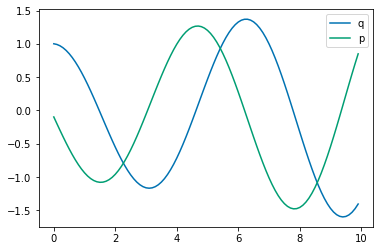

In [10]:
plt.plot(ts, xs[:, 0], label="q")
plt.plot(ts, xs[:, 1], label="p")
plt.legend();

## Using JAX

From here, it's only a small step to using JAX. All I have to do is replace the Python version of `scan` by `lax.scan`, JAX's lower-level implementation.

In [11]:
def integrate_jax(X, method, x0, t0, t1, h):
    transformed = transform_one_step(X, h, method)
    ts = np.arange(t0, t1, h)
    _, xs = lax.scan(transformed, x0, ts)  # this is the only change
    return ts, np.asarray(xs)

In [12]:
x0 = jnp.array([1.0, 0])
ts, xs = integrate_jax(harmonic_oscillator, euler_one_step, x0, 0, 10, 0.1)

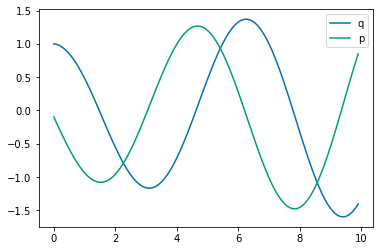

In [13]:
plt.plot(ts, xs[:, 0], label="q")
plt.plot(ts, xs[:, 1], label="p")
plt.legend();

Comparing apples to apples, we get what appears to be at first a nice but modest speedup: one order of magnitude, from 3-400 ms for the Python version down to 41 ms for JAX. But this is deceptive, since the timing for JAX includes the fixed cost of jitting all of those functions...

In [14]:
%%timeit
integrate_python(harmonic_oscillator, euler_one_step, x0, 0, 100, 0.1)

364 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
integrate_jax(harmonic_oscillator, euler_one_step, x0, 0, 100, 0.1)

44.7 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In fact, once the cost of jitting everything has been paid off, the JAX version is able to run across much larger input ranges in essentially the same time.

In [16]:
%%timeit
integrate_jax(harmonic_oscillator, euler_one_step, x0, 0, 100_000, 0.1)

60.4 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Feedback integrators

If you were to take a peek into the output generated by the Euler method after 1 million steps as computed in the above benchmark, you'd find it full of `NaN`s. This is because the Euler method injects a little bit of spurious energy with every step, and eventually something just breaks down. This is obviously not ideal!

In the [Feedback Integrators](https://arxiv.org/abs/1606.05005) paper, the authors propose a way of modifying the dynamics of the continuous dynamical system to make numerical integrators like the Euler method more stable. They do this by incorporating a feedback mechanism into the dynamics, so that any deviations from known conserved quantities are quickly corrected. Note that it is the _continuous_ system that is modified, not the numerical method, and that the feedback mechanism works with any integration scheme.

In a nutshell, the method works by integrating the following system:
$$
  \dot{x} = X(t, x) - \nabla V(x),
$$
where $V(x)$ is suitably chosen Liapunov-like function (see the paper for details).

## The harmonic oscillator

For the harmonic oscillator, the energy $E(q, p) = q^2/2 + p^2/2$ is conserved, and we can use it to create a function 
$$
     V(q, p) = \frac{1}{2}(E(q, p) - E_0)^2,
$$
where $E_0$ is the energy of the system at time 0. The feedback integrator will cause the dynamics to be attracted to the energy hypersurface with energy $E_0$.

In [17]:
@jit
def E(x):
    return jnp.sum(x**2)/2

E0 = E(x0)

def V(x):
    return (E(x) - E0)**2/2

grad_V = grad(V, 0)

All we have to do now is to adjust our harmonic oscillator and integrate again. Note how the trajectories are nicely periodic between -1 and 1, and how we didn't have to adjust our integrate method at all.

In [18]:
@jit
def feedback_harmonic_oscillator(t, x):
    return harmonic_oscillator(t, x) - grad_V(x)

In [19]:
ts, xs = integrate_jax(feedback_harmonic_oscillator, euler_one_step, x0, 0, 10, 0.1)

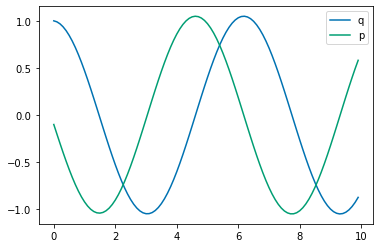

In [20]:
plt.plot(ts, xs[:, 0], label="q")
plt.plot(ts, xs[:, 1], label="p")
plt.legend();

The numerical trajectories still diverge from the exact solution, though, as can be expected from a first-order integrator.

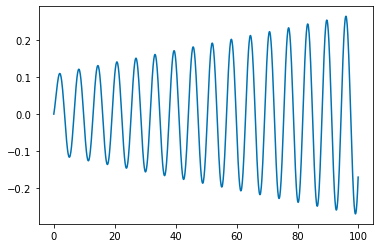

In [21]:
ts, xs = integrate_jax(feedback_harmonic_oscillator, euler_one_step, x0, 0, 100, 0.1)

q_numerical = xs[:, 0]
q_exact = np.cos(ts)

residue = q_exact - q_numerical

plt.plot(ts, residue);

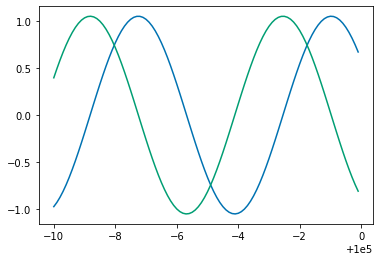

In [22]:
ts, xs = integrate_jax(feedback_harmonic_oscillator, euler_one_step, x0, 0, 100_000, 0.1)

ts_last = ts[-100:]
xs_last = xs[-100:]

plt.plot(ts_last, xs_last);

## Modified Kepler problem

This is an example from the paper. Please see the paper for more details.

In [23]:
mu = 1
delta = 0.0025
e = 0.6  # Eccentricity

h = 0.03  # Step size

# Initial conditions
q0 = jnp.array([1-e, 0, 0])
v0 = jnp.array([0, ((1+e)/(1-e))**0.5, 0])
x0 = jnp.hstack((q0, v0))

# V-parameters
k1 = 2
k2 = 3

E0 = -0.5390625  # Energy 
L0 = jnp.array([0, 0, 0.8])  # Angular momentum

In [24]:
@jit
def U(r):
    return -mu/r - delta/r**3

grad_U = grad(U, 0)

@jit
def mod_kepler(t, x):
    q, v = x[:3], x[3:]
    
    r = jnp.linalg.norm(q)
    return jnp.hstack((v, -grad_U(r)*q/r))

In [25]:
@jit
def E(x):
    q, v = x[:3], x[3:]
    r = jnp.linalg.norm(q)
    return (v*v).sum()/2 + U(r)

@jit
def L(x):
    q, v = x[:3], x[3:]
    return jnp.cross(q, v)

@jit
def V(x):
    return k1/2*(E(x) - E0)**2 + k2/2*jnp.sum((L(x) - L0)**2)

grad_V = grad(V, 0)

In [26]:
@jit
def feedback_mod_kepler(t, x):
    return mod_kepler(t, x) - grad_V(x)

In [27]:
ts, xs = integrate_jax(feedback_mod_kepler, euler_one_step, x0, 0, 200, h)

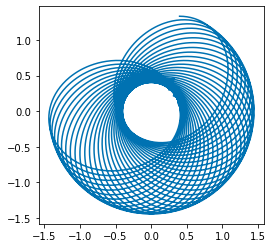

In [28]:
# Compare with fig. 8 in the paper.

plt.plot(xs[:, 0], xs[:, 1])
plt.gca().set_aspect('equal')